[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/042_cnns/cnns.ipynb)

# Laboratorio 3. Redes Neuronales Convolucionales

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1. CONFIGURAR LAS TRANSFORMACIONES Y CARGAR EL DATASET

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

# Ruta al dataset en Google Drive
data_dir = '/content/drive/MyDrive/SIS 421/Lab2/dataset_plantas'

# Transformaciones: Redimensionar si es necesario. Convertir a tensor
transform = transforms.Compose([
    transforms.Resize((189, 252)),
    transforms.ToTensor()
])

# Cargar el dataset con las transformaciones
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Dividir en conjunto de entrenamiento (80%) y conjunto de prueba (20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
trainset, testset = random_split(full_dataset, [train_size, test_size])

# Crear DataLoaders
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

# Imprimir dimensiones
print(f"Total de imágenes en el dataset: {full_dataset}")
print(f"Tamaño del conjunto de entrenamiento: {train_size}")
print(f"Tamaño del conjunto de prueba: {test_size}")

# Verificar los TAMAÑOS DEL PRIMER BATCH en los DataLoaders. batch_size=16
for images, labels in trainloader:
    print("PRIMER BATCH TRAINLOADER")
    print(f"Tamaño de imágenes: {images.size()}")
    print(f"Tamaño de etiquetas: {labels.size()}")

    # Imprimir el valor mínimo y máximo de los tensores de imagen
    print(f"Valor mínimo de los tensores de imagen: {images.min().item()}")
    print(f"Valor máximo de los tensores de imagen: {images.max().item()}")

    break  # Sólo en el primer batch

for images, labels in testloader:
    print("PRIMER BATCH TESTLOADER")
    print(f"Tamaño de imágenes: {images.size()}")
    print(f"Tamaño de etiquetas: {labels.size()}")

    # Imprimir el valor mínimo y máximo de los tensores de imagen
    print(f"Valor mínimo de los tensores de imagen: {images.min().item()}")
    print(f"Valor máximo de los tensores de imagen: {images.max().item()}")
    break  # Sólo el primer batch

# Imprimir las Clases
classes = full_dataset.classes
print("CLASES")
print(classes)

Total de imágenes en el dataset: Dataset ImageFolder
    Number of datapoints: 10010
    Root location: /content/drive/MyDrive/SIS 421/Lab2/dataset_plantas
    StandardTransform
Transform: Compose(
               Resize(size=(189, 252), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Tamaño del conjunto de entrenamiento: 8008
Tamaño del conjunto de prueba: 2002
PRIMER BATCH TRAINLOADER
Tamaño de imágenes: torch.Size([16, 3, 189, 252])
Tamaño de etiquetas: torch.Size([16])
Valor mínimo de los tensores de imagen: 0.0
Valor máximo de los tensores de imagen: 1.0
PRIMER BATCH TESTLOADER
Tamaño de imágenes: torch.Size([16, 3, 189, 252])
Tamaño de etiquetas: torch.Size([16])
Valor mínimo de los tensores de imagen: 0.0
Valor máximo de los tensores de imagen: 1.0
CLASES
['laurel', 'limon', 'membrillo', 'olivo', 'papaya']


##2. VISUALIZACIÓN DE LAS IMÁGENES

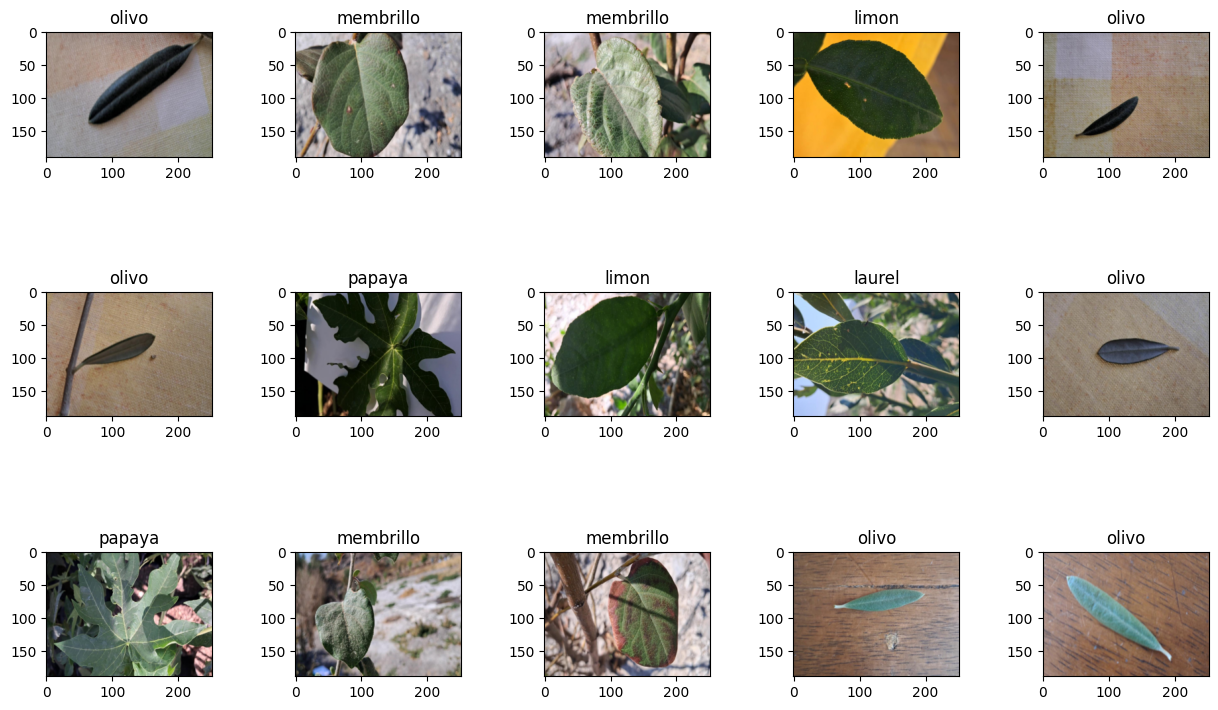

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.numpy()  # Convertir a numpy array
    img = np.transpose(img, (1, 2, 0))  # Cambiar el formato a (H, W, C)
    plt.imshow(img)
    plt.axis('on')  # Activar los ejes para mostrar las dimensiones
    #plt.xlabel(f'Width: {img.shape[1]} px')
    #plt.ylabel(f'Height: {img.shape[0]} px')

r, c = 3, 5
plt.figure(figsize=(c * 3, r * 3))

for row in range(r):
    for col in range(c):
        index = c * row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset) - 1)
        img, label = trainset[ix]

        # Visualizar imagen
        imshow(img)
        plt.title(classes[label])

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


##3. Definir la red convolucional para 5 clases

In [ ]:
# block() ES UNA FUNCIÓN QUE CREA UN BLOQUE DE CAPAS COMUNES EN LAS CNNs

def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(                                                 # CREO UNA SECUENCIA DE EJECUCIÓN
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),                   # VOY APLICAR UNA CONVOLUCIONAL 2D, LE PASO (c_in,c_out, k, p, s)
                                                                                # EL TAMAÑO DE LAS CAPAS DE SALIDA MULTIPLICADO POR LOS BATCHES
        torch.nn.ReLU(),                                                        # LE APLICO RELU() -> TRANSFORMA CUALQUIER VALOR ENTRE 0 Y EL INFINITO (POSITIVO)
        torch.nn.MaxPool2d(pk, stride=ps)                                       # LUEGO VIENE EL MaxPool2d DONDE LE DIGO QUE LE APLIQUE KERNEL DE 2 Y STRIDE DE 2 PARA REDUCIR EL TAMAÑO DE LA IMG
                                                                                # LA CONVOLUCION YA REDUCE EL TAMAÑO DE LA IMAGEN PERO EL POOLING REDUCE AÚN MÁS
    )

# block2 CREA UN BLOQUE DE CAPAS LINEALES CON UNA ACTIVACIÓN ReLU
def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU()
    )

# DEFINICIÓN DE LA CLASE CNN (PUEDE SER CUALQUIER NOMBRE)
# 1. AQUÍ SÓLO DEFINO QUÉ CONVOLUCIONES VOY A APLICAR, AQUÍ CONFIGURO TODO

class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=5):                                #EN LA PARTE DE __init__ SOLO SE DEFINE EN PYTHON, NO USAMOS. TENEMOS 3 canales Y 5 salidas
    super().__init__()

    self.conv1 = block(n_channels, 64)            # Primer bloque convolucional con 64 filtros
                                                  # EL NUMERO DE FILTROS QUE APLICO determina el número de canales de salida. EL TAMAÑO LO DETERMINA LA CONFIGURACIÓN DE padding, stride, pooling
    self.conv2 = block(64, 128)                   # Segundo bloque convolucional con 128 filtros
                                                  # BOTA 128 CANALES DE SALIDA, NO ES UNA IMAGEN QUE TENGA 128 CANALES SINO SON 128 FILTROS QUE CAPTAN 128 COSAS DIFERENTES
                                                  # LA CLAVE ES LA ÚLTIMA CAPA. HAY UNA DIMENSION QUE SE TIENE QUE CALCULAR: FÓRMULA DE 'o'
    self.conv3 = block(128, 256)                  # # Tercer bloque convolucional con 256 filtros

    # DESPUÉS DE LAS 2 CONVOLUCIONES EL TAMAÑO DE LA IMAGEN SE REDUCE
    self.fc = torch.nn.Linear(256 * 23 * 31, n_outputs)       # self.fc: Capa full connected toma 128 * 23 * 31 entradas y las convierte en n_outputs salidas, que representan las clases de salida.

    self.printed_shapes = False  # Variable de control


   #2. AQUÍ SE EJECUTA, AQUÍ ES DONDE APLICO, AQUÍ LE PASO EL VALOR
  def forward(self, x):               # MÉTODO forward() DEFINE COMO LOS DATOS FLUYEN A TRAVÉS DE LA RED
    if not self.printed_shapes:
      print("Dimensiones:")
      print("Entrada: ", x.shape)

    x = self.conv1(x)                 #LE APLICO LA conv1 PASANDOLE x Y VOY A VER EL SHAPE DE x
    if not self.printed_shapes:
      print("conv1: ", x.shape)


    x = self.conv2(x)                 #LE APLICO LA conv2 PASANDOLE x Y VOY A VER EL SHAPE DE x
    if not self.printed_shapes:
      print("conv2: ", x.shape)

    x = self.conv3(x)
    if not self.printed_shapes:
      print("conv3: ", x.shape)

    x = x.view(x.shape[0], -1)        # QUIERO QUE LA IMAGEN QUE ESTA CON ALTO Y ANCHO SEA UN VECTOR PLANO
                                      # Después de las convoluciones, el tensor es aplanado (con x.view) para que pueda pasar por la capa totalmente conectada (fc)
    if not self.printed_shapes:
      print("pre fc: ", x.shape)      #VALOR DE x APLANADO, YA NO NECESITA DOS VALORES

    x = self.fc(x)                    # LE APLICA LA FULL CONECTED Y VA A DEVOLVER LOS VALORES DE SALIDA QUE EN ÉSTE CASO ES 5
    if not self.printed_shapes:
      print("Salida: ", x.shape)
      self.printed_shapes = True

    return x


In [ ]:
# Definir el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Crear el modelo
model = CNN()
model.to(device)

# Mover el tensor de entrada al mismo dispositivo que el modelo
input_tensor = torch.randn(64, 3, 189, 252).to(device)

# Pasar el tensor a través del modelo
output = model(input_tensor)


Dimensiones:
Entrada:  torch.Size([64, 3, 189, 252])
conv1:  torch.Size([64, 64, 94, 126])
conv2:  torch.Size([64, 128, 47, 63])
conv3:  torch.Size([64, 256, 23, 31])
pre fc:  torch.Size([64, 182528])
Salida:  torch.Size([64, 5])


##4. Definir la función de Entrenamiento

In [ ]:
# Definir la función de entrenamiento
from tqdm.notebook import tqdm              # tqdm MUESTRA LA BARRA DE PROGRESO DURANTE LA EJECUCIÓN DE BUCLES
import numpy as np

# Verifica si hay una GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mueve el modelo al dispositivo adecuado
model = CNN()
model.to(device)

# FUNCION DE ENTRENAMIENTO
def fit(model, dataloader, epochs=5):       # FUNCIÓN QUE SE ENCARGA DE ENTRENAR Y EVALUAR EL MODELO. LE PASO UN modelo, UN dataloader Y LOS epochs
                                            # Como son modelos grandes vamos usar pocos epochs.

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)     # Se define el optimizador Adam con lr de 1e-3. El optimizador ajusta los pesos del modelo durante el entrenamiento
    criterion = torch.nn.CrossEntropyLoss()                       # Función de pérdida para calcular qué tan lejos están las predicciones (y_hat) del modelo de las etiquetas verdaderas (y)


    # BUCLE DE ENTRENAMIENTO

    for epoch in range(1, epochs + 1):      # Iteraciones en el bucle de acuerdo al número de epochs

        model.train()                       # Pone al modelo en modo de entrenamiento, lo que permite actualizar los pesos durante el proceso de optimización

        train_loss, train_acc = [], []      # Listas para almacenar la pérdida y la precisión durante el entrenamiento de cada batch
        bar = tqdm(dataloader['train'])     # Se crea una barra de progreso tqdm para el conjunto de entrenamiento

        for batch in bar:     # EN LUGAR DE ITERAR EN EL dataloader, LAS VOY HACER EN EL batch POR CADA ELEMENTO. #Bucle itera a través de cada batch en el conjunto de entrenamiento
                              # COMO EL dataloader ESTA BATCHEADO ME VA A SACAR batches EN bar
            X, y = batch      # Extrae las imágenes (X) y las etiquetas (y) del batch
            X, y = X.to(device), y.to(device)   # Mueve los datos al dispositivo especificado (GPU o CPU)

            optimizer.zero_grad()     # PONGO LOS GRADIENTES A CERO

            y_hat = model(X)          # Realiza una predicción con el modelo pasandole x
            loss = criterion(y_hat, y)    # Calcula la pérdida entre las predicciones y las etiquetas verdaderas
            loss.backward()               # A PARTIR DEL ERROR CALCULO LOS GARDIENTES POR EL DESCENSO POR EL GRADIENTE
            optimizer.step()              # Actualiza los pesos del modelo según los gradientes calculados

            train_loss.append(loss.item())    # Almacena la pérdida del batch
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)      # Calcula la precisión del batch, comparando las predicciones con las etiquetas verdaderas
                                                                                # SI RECONOCE LOS 64 LA SUMA VA A SER 64, LUEGO 64/64 =1 (UNA PRECISIÓN ALTA). SI SALE 1/64 LA PRECISION ES BAJA
            train_acc.append(acc)     # Almacena la precisión del batch

            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")   # Actualiza la barra de progreso con la pérdida y precisión promedio actuales


        # BUCLE DE EVALUACIÓN (VALIDACIÓN)

        bar = tqdm(dataloader['test'])        # Crea una barra de progreso tqdm para el conjunto de prueba.
        val_loss, val_acc = [], []            # Listas para almacenar la pérdida y precisión durante la evaluación de cada batch

        model.eval()            # Pone al modelo en modo de evaluación, lo que desactiva ciertos comportamientos como el dropout
        with torch.no_grad():   # NO CALCULAR LOS GRADIENTES. Desactiva el cálculo de gradientes para ahorrar memoria y acelerar el proceso de evaluación

            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)  # Asegura que los datos de validación estén en el dispositivo

                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)

                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")


####Preparar los dataloaders en un diccionario

In [ ]:
dataloader = {
    'train': trainloader,
    'test': testloader
}

##5. Entrenar el modelo

In [ ]:
# LLAMA A fit(), PASA EL MODELO Y DATALOADER

model = CNN().to(device)      # Crea una instancia de la clase CNN, que representa la red neuronal convolucional definido anteriormente
fit(model, dataloader)        # Llama a la función fit pasando como argumentos el modelo (model) y el diccionario de dataloaders (dataloader).

  0%|          | 0/501 [00:00<?, ?it/s]

Dimensiones:
Entrada:  torch.Size([16, 3, 189, 252])
conv1:  torch.Size([16, 64, 94, 126])
conv2:  torch.Size([16, 128, 47, 63])
conv3:  torch.Size([16, 256, 23, 31])
pre fc:  torch.Size([16, 182528])
Salida:  torch.Size([16, 5])


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 1/5 loss 0.79481 val_loss 0.42690 acc 0.68276 val_acc 0.83879


  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 2/5 loss 0.31293 val_loss 0.25357 acc 0.88785 val_acc 0.91071


  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 3/5 loss 0.17696 val_loss 0.18206 acc 0.93900 val_acc 0.93948


  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 4/5 loss 0.11764 val_loss 0.21878 acc 0.95996 val_acc 0.93254


  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 5/5 loss 0.06564 val_loss 0.22557 acc 0.97792 val_acc 0.93800


##6. Observaciones
El modelo con tres capas convolucionales aumenta la precisión del Conjunto de validación de val_acc=0.86850 a val_acc=0.93800.